In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.style as style
import numpy as np
import seaborn as sns
import math
import numpy as np
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from datetime import datetime
from wordcloud import WordCloud
import warnings
import squarify
warnings.filterwarnings("ignore")

<h2>Tema</h2>

En este NoteBook vamos a analizar tres factores que influencia del clima y la guerra Rusia-Ukrania en la agricultura de Ecuador, tomando como muestra la zona de Costa (zona con mayor produccion agricicola del pais) y como indicadores económicos las importaciones de Urea al pais y los precios bursátiles de la Urea y el Gas Natural.

<h2>Hipótesis</h2>

<h5>1. El impacto de Rusia</h5>

    La guerra entre Rusia y Ucrania iniciada en 2022, han incrementado la volatilidad de los precios internacionales. 
<h5>2. La guerra en los costes</h5>

    Este evento ha impactado directamente los costos agrícolas.
<h5>3. El aftermath</h5>

    Este evento ha acentado a Rusia como socio comercial de Ecuador.
<h5>4. Corelacción entre temperatura y precipitación en la Costa Ecuatoriana</h5>

    Existe una correlación entre la tempratura y la precipitación.
<h5>5. Impacto de la precipitación en los volúmenes de importación.</h5>

    La variaciones en las precipitaciones  en la Costa de Ecuador (enero-marzo) impactan directamente los volumenes de importacion.



<h2>Creación del Data Set</h2>

Para la creación del DataSet, se ha procedido a extraer información de la página: Investing.com - un portal financiero global que proporciona información sobre mercados, precios de commodities (materias primas). Se obtuvo precios históricos en sus variaciones desde 2017 para la Urea y desde 2009 para el Gas Natural. Esta financiera se complemento con los datos de importaciones de fertilizantes a Ecuador, que se obtuvo del portal de Cobbus Ecuador, empresa de Big Data para empresas latinas.

Por último los datos de precipitación y tempratura en la ciudad de Guayaquil, se obtuvieron tomando de referencia la geolocalización del Aeropuerto de Guayaquil. Esta información se obtuvo de el sitio web del Centro Nacional de Información Ambiental (NCEI) de la NOAA (Administración Nacional Oceánica y Atmosférica de EE.UU.).

El proceso de extracción fue relativamente simple, siendo que se obtuvieron directamente los csv.

Con respecto a la limpieza, tenemos en el repo una memoria del proceso, pero como comentario general, siendo que la mayoría eran datos numéricos desde 2009, y se busco crear relaciones entre las tres fuentes de datos, fue un proceso exhaustivo pero necesario para la calidad del dato.

Podemos revisar el proceso en: "Memoria Limpieza de Datos"

<h2>Análisis</h2>

<h3>Macro</h3>

Primero vamos a ponernos en situación en los macros del mercado actual. Para esto visualizaremos los gráficos de la Urea y del Gas Natural superpuestos, así podemos ver su corerlación y la acción de precio en los últimos años.

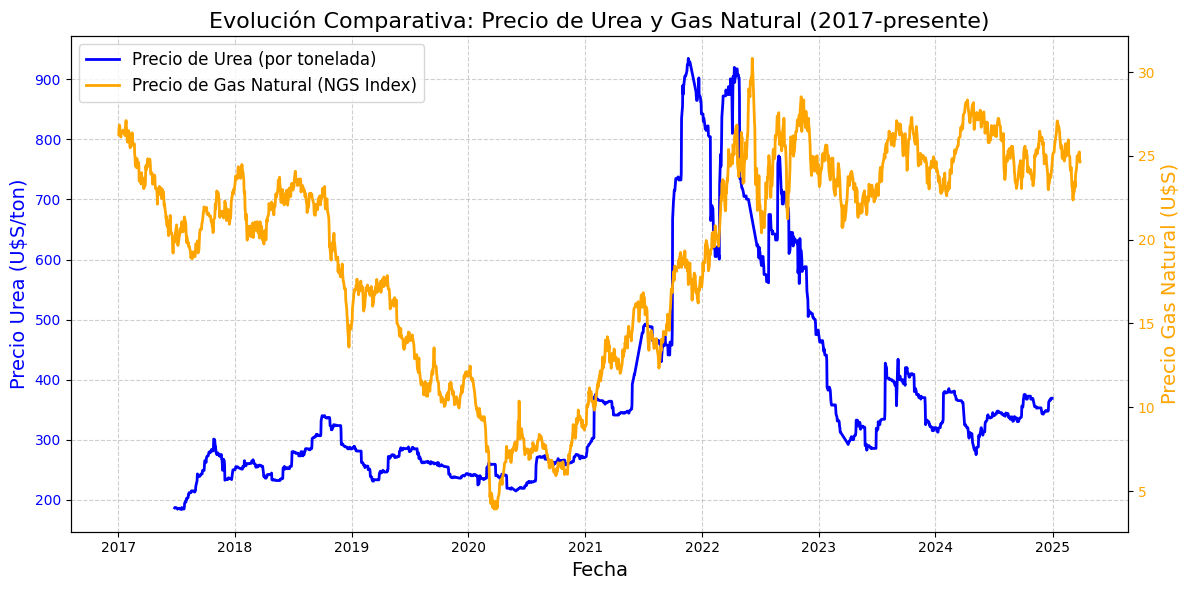

In [109]:
urea = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/precios_historicos/data_1_precio_urea_filtrada.csv')
gas_nat = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/precios_historicos/data_1_precio_nat_gas_filtrado.csv')

urea['FECHA'] = pd.to_datetime(urea['FECHA'])
gas_nat['FECHA'] = pd.to_datetime(gas_nat['FECHA'])

urea_filtered = urea[urea['FECHA'] >= '2017-01-01']
gas_nat_filtered = gas_nat[gas_nat['FECHA'] >= '2017-01-01']

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

line1 = ax1.plot(urea_filtered['FECHA'], urea_filtered['Price'], label='Precio de Urea (por tonelada)', color='blue', linewidth=2)

line2 = ax2.plot(gas_nat_filtered['FECHA'], gas_nat_filtered['Price'], label='Precio de Gas Natural (NGS Index)', color='orange', linewidth=2)

ax1.set_xlabel('Fecha', fontsize=14)
plt.xticks(rotation=45)

ax1.set_ylabel('Precio Urea (U$S/ton)', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2.set_ylabel('Precio Gas Natural (U$S)', fontsize=14, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Evolución Comparativa: Precio de Urea y Gas Natural (2017-presente)', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.6)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

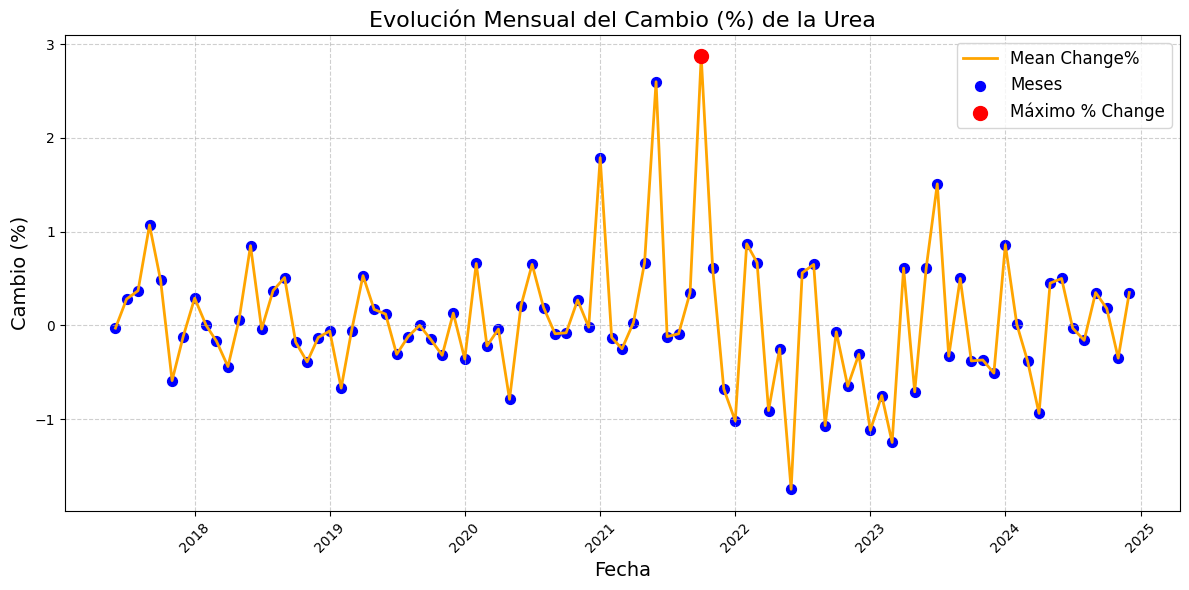

In [110]:
urea_mensual = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/precios_historicos/promedio_precio_por_mes_urea.csv')

urea_mensual['FECHA'] = pd.to_datetime(urea_mensual[['Year', 'Month']].assign(Day=1))

urea_mensual['Mean Change%'] = urea_mensual['Mean Change%'].str.replace('%', '').astype(float)

plt.figure(figsize=(12, 6))

plt.plot(urea_mensual['FECHA'], urea_mensual['Mean Change%'], label='Mean Change%', color='orange', linewidth=2)

plt.scatter(urea_mensual['FECHA'], urea_mensual['Mean Change%'], color='blue', s=50, label='Meses')

max_change = urea_mensual['Mean Change%'].max()
max_change_point = urea_mensual[urea_mensual['Mean Change%'] == max_change]
plt.scatter(max_change_point['FECHA'], max_change_point['Mean Change%'], color='red', s=100, label='Máximo % Change', zorder=5)

plt.title('Evolución Mensual del Cambio (%) de la Urea', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cambio (%)', fontsize=14)

plt.xticks(rotation=45)

# Agregar una cuadrícula
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


Ahora visualizamos el cambio mensual en % en precio de la Urea, así podemos ver con una perspectiva más amplia como se ha comportado el activo y su volatilidad.

<h3>Hipótesis 1: Tomando de referencia el 24 de febrero de 2022</h3>

Podemos ver:

Si no tomamos en cuenta covid, 2022 fue unos de los anos tanto de mayor apreciación tanto para el gas Natural como para la Urea, que es un derivado del Gas Natural.

En el graficos de price changes de la Urea podemos ver un contraste entre antes de COVID y despues de covid, una subida en la volatilidad. Esto más que nada confirma que COVID trajo un cambio, pero podemos concluir que ese cambio se reforzó por la Guerra.

<h3>Situación país</h3>

Una vez tenemos claro la situación macro, me gustaría contextualizar el mercado agrícula ecuatoriano, pero no como un exportador (suplidor), sino como un importador (demandande) de fertilizantes.

Siendo que los datos en mercados agrícolas son difíciles de conseguir, por la informalidad de estos negocios, y más aún en un país latino como Ecuador, donde los pequeños agriculas representan gran parte del mercado, vamos a tomar como referencia las importaciones de fertilizantes al país.

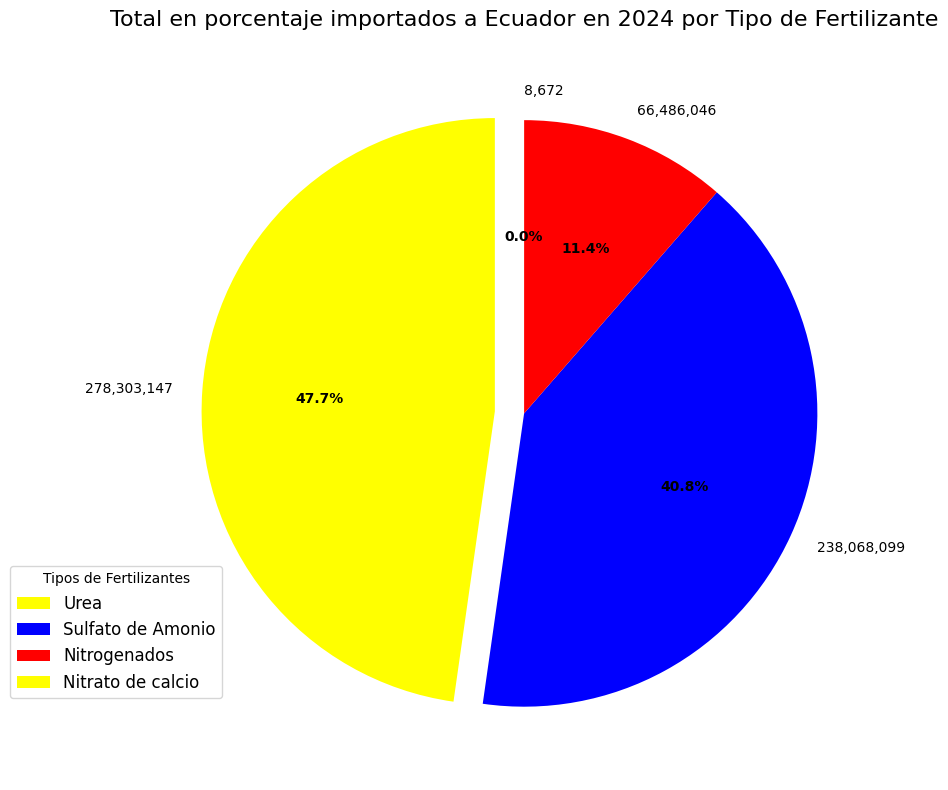

In [ ]:
mercado_pais = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/resultado_mercado_fertilizantes_2024_porcentaje.csv')

mercado_pais.set_index("Tipo de Fertilizante", inplace=True)

valores = mercado_pais["Volumen Total en KGS"].values
labels = [f"{x:,.0f}" for x in valores]

colores = ['yellow', 'blue', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(12, 8))

# Con ax.pie puedo eliminar la etiqueta
wedges, texts, autotexts = ax.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    explode=(0.1, 0, 0, 0),
    colors=colores,
    startangle=90
)

plt.setp(autotexts, size=10, weight="bold")

ax.set_title("Total en porcentaje importados a Ecuador en 2024 por Tipo de Fertilizante", 
             fontsize=16, 
             loc='center', 
             pad=15)  

ax.legend(
    wedges,
    mercado_pais.index,
    title="Tipos de Fertilizantes",
    loc="lower right",
    bbox_to_anchor=(0.1, 0.1),
    fontsize=12
)

plt.tight_layout()
plt.show()

Tener en cuenta que la urea es un producto listo para venderse, no como el Sulfato de Amonio, Nitrogenados y Nitrato de calcio, los cuales son productos que tienen subproductos y se distribuyen en mezclas. Podemos ver la clara dominancia de la urea.

Ahora vemos los costos y cantidades de importaciones año a año

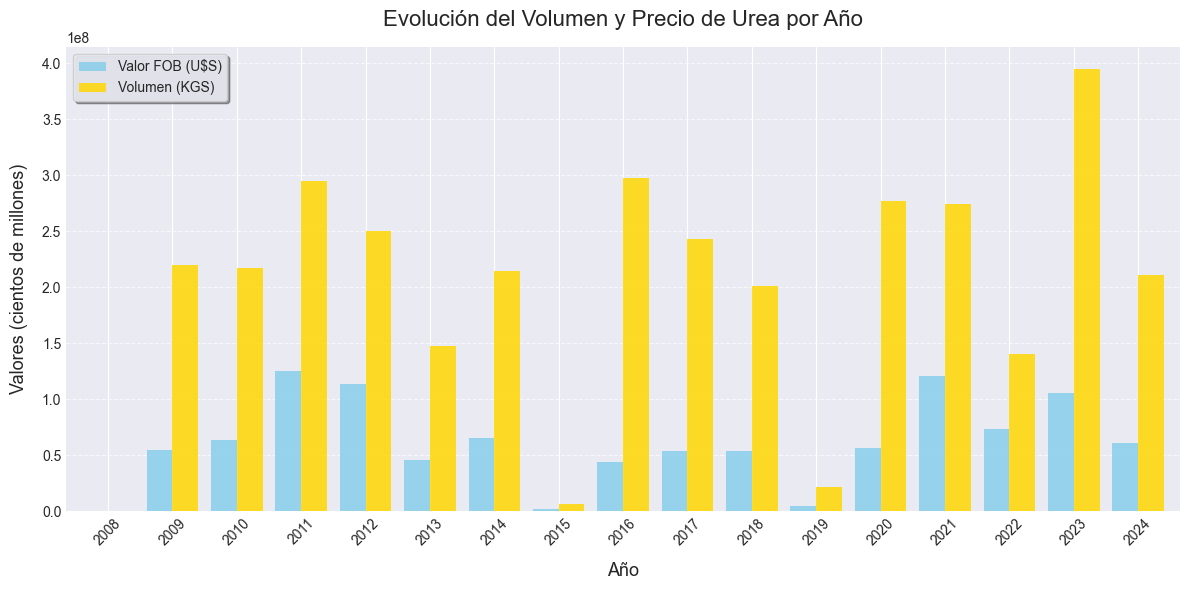

In [ ]:
fob_kgs_anual = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/fob_kgs/fob_kgs_anual.csv')

style.use('seaborn-v0_8-darkgrid')

fig, ax = plt.subplots(figsize=(12, 6))

colores = ['#87CEEB', '#FFD700'] 

fob_kgs_anual.plot(
    x='Year', 
    y=['FOB U$S Total', 'TOTAL KGS NETO'], 
    kind='bar', 
    color=colores,
    alpha=0.85,  
    width=0.8,   
    ax=ax
)

plt.xlabel('Año', fontsize=13, labelpad=10)
plt.ylabel('Valores (cientos de millones)', fontsize=13, labelpad=10)
plt.title('Evolución del Volumen y Precio de Urea por Año', fontsize=16, pad=15)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.legend(
    ['Valor FOB (U$S)', 'Volumen (KGS)'], 
    frameon=True, 
    fancybox=True, 
    shadow=True, 
    framealpha=0.9,
    loc='upper left'
)

plt.tight_layout()
plt.show()

<h3>Hipótesis 2: Tomando en cuenta los costos antes y despues de la guerra:</h3>

Lo que podemos ver claramente es la fuerte correlación mes a mes que tienen el precio y la cantidad la Urea en Ecuador y en general en el mundo siendo que las commodities se mueven por oferta y demanda.
Por otro lado ya viendo las barras año a año podemos ver que el año concecuente a la guerra, se disparo la compra, con el valor commprado cercanos a los mas altos desde 2009 y en cantidades las más altas desde 2009. 
Esto nos hace plantear la teoría de que este mercado estacional reacciona tardiamente a sucesos.

<h3>¿Principal partner? ¿De donde vienen las importaciones?</h3>

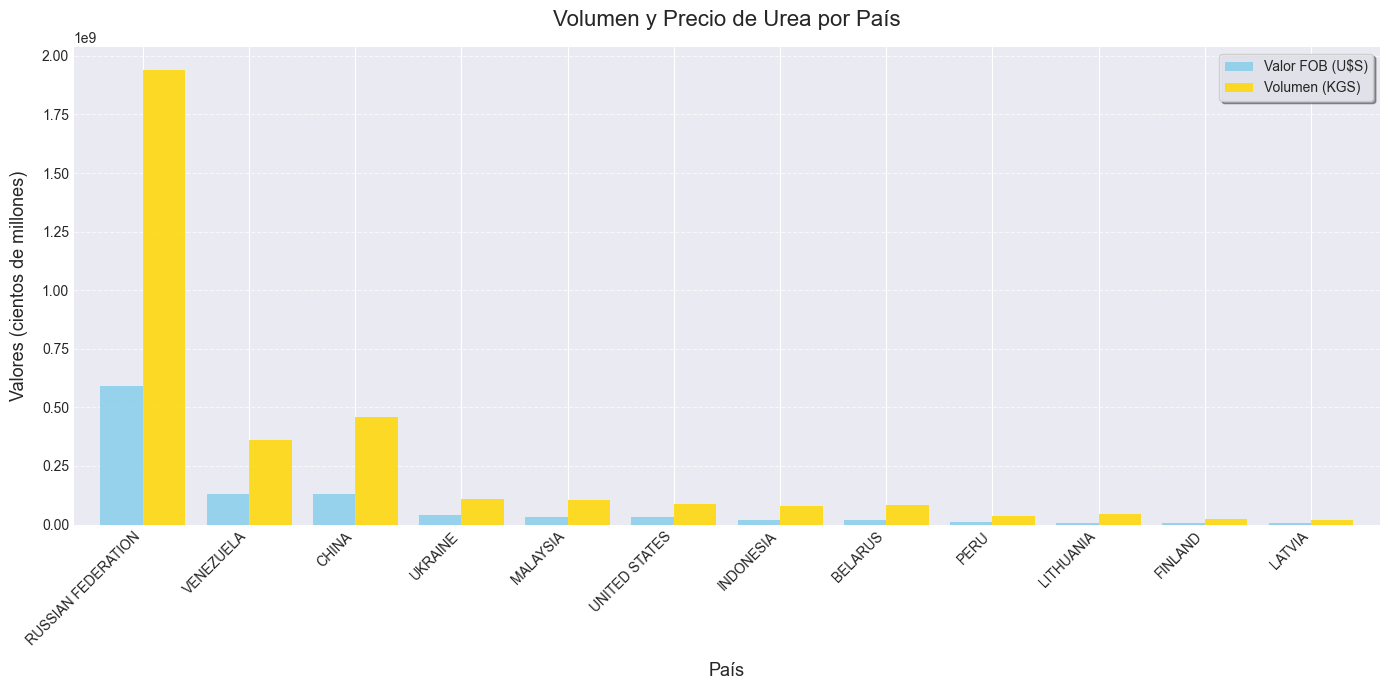

In [122]:
resumen_por_pais = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/resumen_por_pais.csv')

style.use('seaborn-v0_8-darkgrid')

fig, ax = plt.subplots(figsize=(14, 7))

data_subset = resumen_por_pais.head(12)

colores = ['#87CEEB', '#FFD700']  

data_subset.plot(
    x='País', 
    y=['FOB Total', 'KGS NETO Total'], 
    kind='bar', 
    color=colores,
    alpha=0.85,  
    width=0.8,  
    ax=ax
)

plt.xlabel('País', fontsize=13, labelpad=10)
plt.ylabel('Valores (cientos de millones)', fontsize=13, labelpad=10)
plt.title('Volumen y Precio de Urea por País', fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right')  
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.legend(
    ['Valor FOB (U$S)', 'Volumen (KGS)'], 
    frameon=True, 
    fancybox=True, 
    shadow=True, 
    framealpha=0.9,
    loc='upper right'  
)

plt.tight_layout()
plt.show()

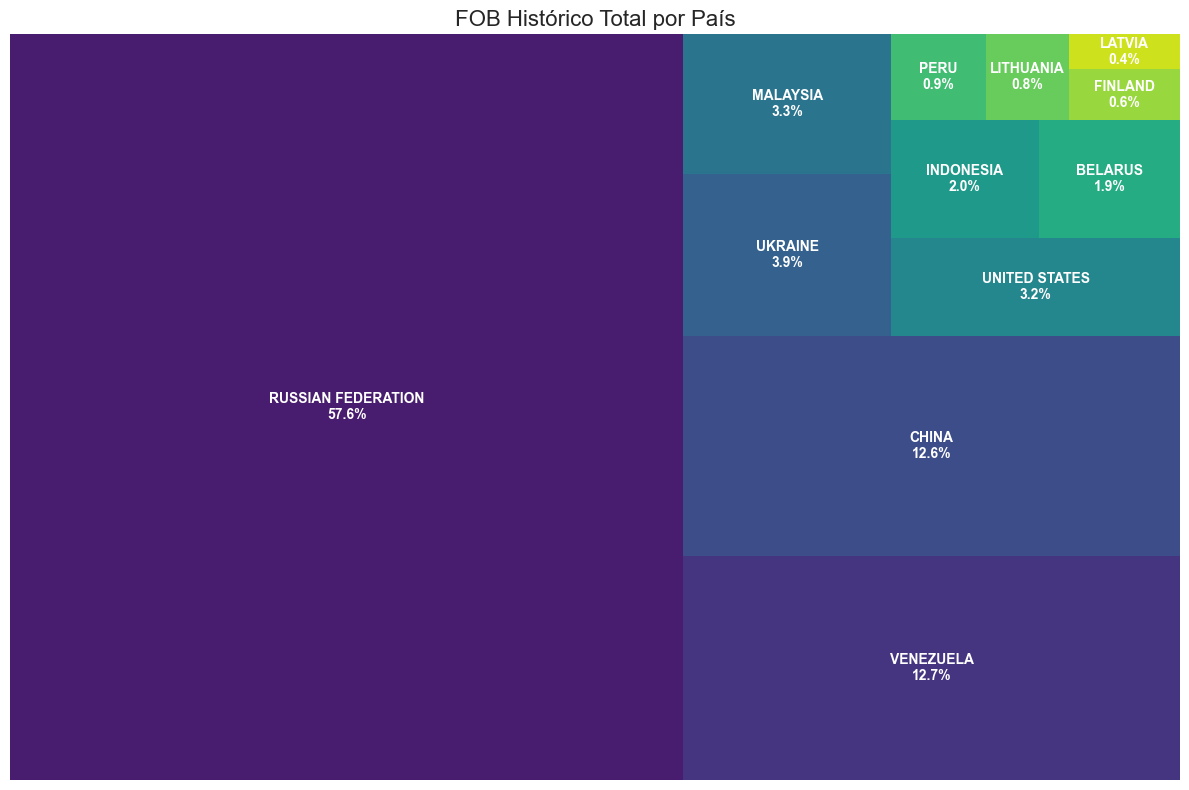

In [128]:
resumen_por_pais = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/resumen_por_pais.csv')

data = resumen_por_pais.head(12).sort_values('FOB Total', ascending=False)
data['Porcentaje'] = (data['FOB Total'] / data['FOB Total'].sum()) * 100
data['Etiqueta'] = data.apply(lambda x: f"{x['País']}\n{round(x['Porcentaje'], 1)}%", axis=1)

plt.figure(figsize=(12, 8))

colores = sns.color_palette("viridis", len(data))
squarify.plot(
    sizes=data['FOB Total'],
    label=data['Etiqueta'],
    color=colores,
    pad=0, 
    text_kwargs={'color': 'white', 'fontweight': 'bold'}
)

plt.title('FOB Histórico Total por País', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

<h3>Hipótesis 3: Rusia como principal partner</h3>

Siendo que la data mostrada es desde 2009, se puede estar seguro que con la guerra y el como esto exprimió la oferta de Urea en el mercado, Rusia consiguió asentarse como socio principal de urea en el Ecuador.

<h3>El clima y la agricultura en Ecuador</h3>

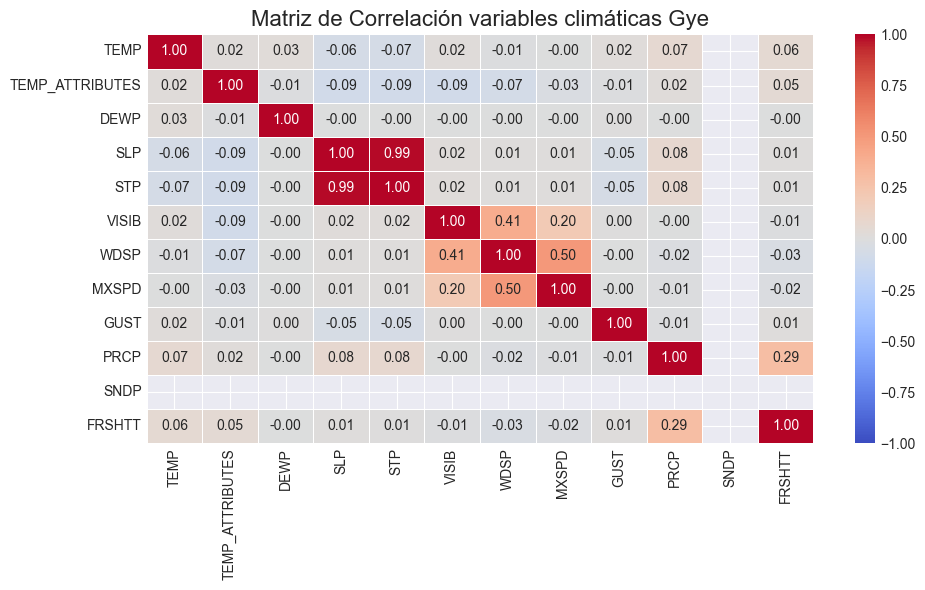

In [ ]:
data_total_clima_para_matriz = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/clima_si/data_total_clima_para_matriz')

correlation_matrix = data_total_clima_para_matriz.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm',  
    fmt='.2f',  
    linewidths=0.5,  
    cbar=True,  
    vmin=-1, vmax=1  
)

plt.title('Matriz de Correlación variables climáticas Gye', fontsize=16)
plt.tight_layout()
plt.show()

<h4>Correlaciones encontradas: </h4>

STP(Station Pressure)-SLP(Sea Level Pressure), correlacion de 0.99: La primera es la presión atmosférica medida en la estación meteorológica, la segunda es la presión atmosférica ajustada al nivel del mar. Son dos presiones atmosfericas que se mueven juntas.

WDSP (Wind Speed)-VISIB (Visibility), correlacion de 0.41: La primera representa la velocidad del viento, la segunda la visibilidad horizontal. Hace sentido su correlacion.

MXSPD (Maximum Wind Speed)-WDSP (Wind Speed): Correlacion obvia.


Ahora que la matriz de correlacion no nos ha dado ningun insight, pasamos a graficar la precipitacion promedio de guayaquil en los 12 meses a lo largo del tiempo. Hemos obtenido este dato de limpiar la precipitacion desde 2009 de Guayquil.

<h3>Hipótesis 4: Correlaciones en el clima de Guayaquil</h3>

Esta hipotesis queda inconclusa, ya que ninguna correlacion resalta entre las variables climaticas.

<h3>La precipitación y los volumenes de importación tienen alguna relación entre si</h3>


Para esto vamos a visualizer la precipitación promedio en guayaquil de enero y diciembre, super puesto con el valor de las importaciones promedio de urea al Ecuador.

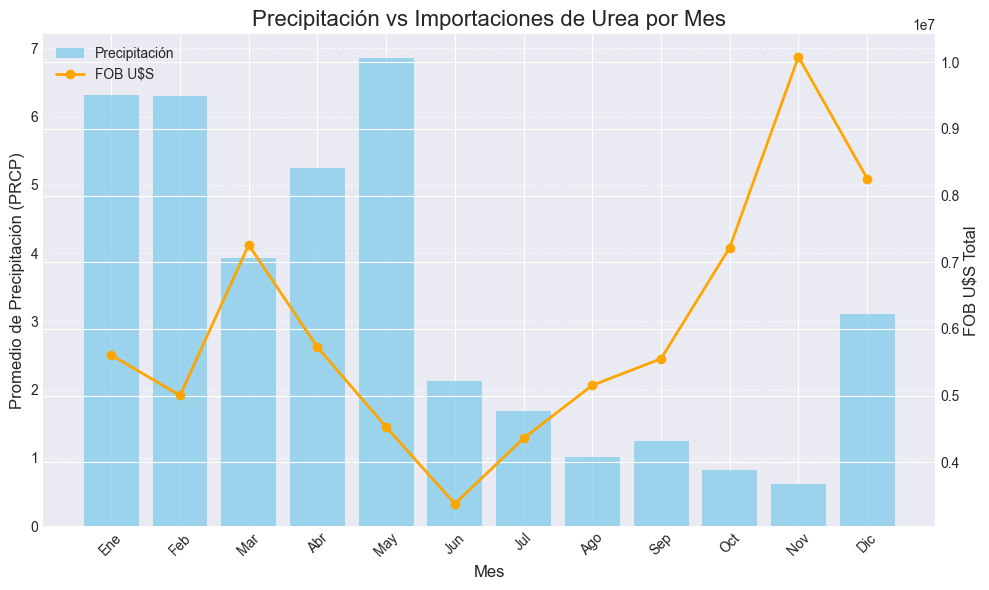

In [132]:
promedio_prcp_por_mes = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/clima_si/promedio_prcp_por_mes.csv')
merge_clima_kg_fob = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/clima_si/merge_clima_kg_fob.csv')

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.bar(promedio_prcp_por_mes['Month'], promedio_prcp_por_mes['Promedio PRCP'], color='skyblue', alpha=0.8, label='Precipitación')

ax2.plot(merge_clima_kg_fob['Month'], merge_clima_kg_fob['FOB U$S Total'], color='orange', marker='o', linewidth=2, label='FOB U$S')

ax1.set_xlabel('Mes', fontsize=12)
ax1.set_ylabel('Promedio de Precipitación (PRCP)', fontsize=12)
ax2.set_ylabel('FOB U$S Total', fontsize=12)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Precipitación vs Importaciones de Urea por Mes', fontsize=16)
plt.tight_layout()
plt.show()

Para terminar de ver el claro de patrón que refuerza la teroía de que los importadores ecuatorianos compran en preparación o en reacción a la época de lluvia, podemos ver en un scatterplot los días en los últimos años en los que ha habido una precipitación mayor al mean (de 2,9).

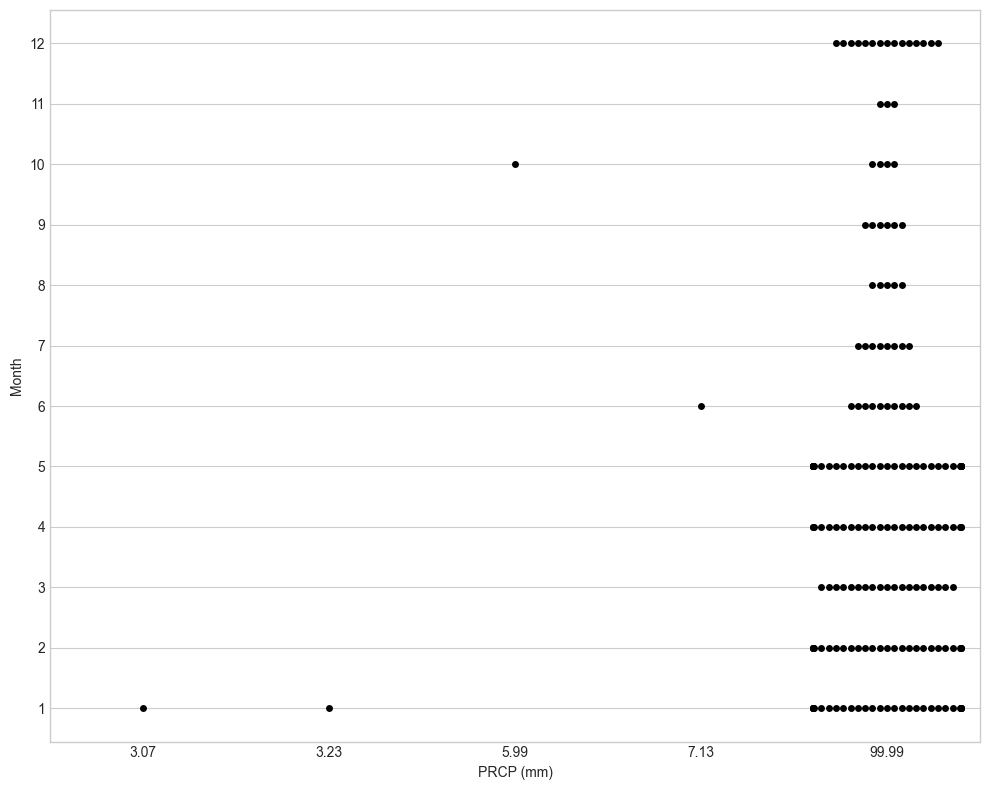

In [149]:
resumen_dias_lluvia_desagrupado = pd.read_csv('/Users/auric/REPO_TEST/Entregas/Entrega 28 - 03 de abril de marzo/EDA Agricultura_Clima Ecuador/EDA/Data_2/clima_si/resumen_dias_lluvia_desagrupado.csv') 

df_gfw = resumen_dias_lluvia_desagrupado[resumen_dias_lluvia_desagrupado['PRCP'].isin([3.07, 3.23, 99.99, 7.13, 5.99])]

plt.figure(figsize=(10, 8))

sns.swarmplot(x="PRCP", y="Month", data=df_gfw, color='black')

plt.xlabel('PRCP (mm)')

plt.yticks(range(1, 13))

plt.tight_layout()
plt.show()

<h3>Hipótesis 5: La precipitacion y el volumen de compras</h3>

Podemos ver que los volumenes de compras tocan sus puntos mas altos el mes antes a los de mayor precipitacion o en los meses durante. 

<h1>FINAL</H1>